In [1]:
%reload_ext autoreload
%autoreload 2

# Static potential

In [2]:

#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 06/2023
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

from models.segmented_trap import SegmentedTrap

from pathlib import Path
data_dir = Path('.').resolve() / 'data'

trap = SegmentedTrap()

n_samples = 1
waveform = init_waveform(n_samples, trap.n_electrodes)

x0 = 0
r0 = (x0, 0, trap.z0)
ion = Ca40
axial_curv = freq_to_curv(1e6, ion=Ca40)
radial_curv = 2.5e7


objectives = [
    obj.GradientObjective(waveform[0], trap, *r0, value=0, ion=Ca40),
    obj.HessianObjective(waveform[0], trap, *r0, entries='xx', value=axial_curv, ion=Ca40),
    obj.HessianObjective(waveform[0], trap, *r0, entries='yz', value=radial_curv, ion=Ca40),
 
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
]

solver_results = solver(objectives, verbose=True)
waveform = solver_results.waveform.value  # get array from cvxpy variable

savename = data_dir / 'waveform_static_segmented_trap.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


Compiling objectives: 100%|██████████| 6/6 [00:00<00:00, 385.00it/s]

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Nov 14 08:55:33 AM: Your problem has 6 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 14 08:55:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 14 08:55:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 14 08:55:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 14 08:55:33 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 14 08:55:33 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->



(CVXPY) Nov 14 08:55:33 AM: Problem
(CVXPY) Nov 14 08:55:33 AM:   Name                   :                 
(CVXPY) Nov 14 08:55:33 AM:   Objective sense        : max             
(CVXPY) Nov 14 08:55:33 AM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Nov 14 08:55:33 AM:   Constraints            : 10              
(CVXPY) Nov 14 08:55:33 AM:   Cones                  : 4               
(CVXPY) Nov 14 08:55:33 AM:   Scalar variables       : 31              
(CVXPY) Nov 14 08:55:33 AM:   Matrix variables       : 0               
(CVXPY) Nov 14 08:55:33 AM:   Integer variables      : 0               
(CVXPY) Nov 14 08:55:33 AM: 
(CVXPY) Nov 14 08:55:33 AM: Optimizer started.
(CVXPY) Nov 14 08:55:33 AM: Presolve started.
(CVXPY) Nov 14 08:55:33 AM: Linear dependency checker started.
(CVXPY) Nov 14 08:55:33 AM: Linear dependency checker terminated.
(CVXPY) Nov 14 08:55:33 AM: Eliminator started.
(CVXPY) Nov 14 08:55:33 AM: Freed constraints in eliminator : 0
(CVXP

## Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from models.segmented_trap import SegmentedTrap
from models.segmented_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout, plot_potential

from pytrans.ions import Ca40

trap = SegmentedTrap()
waveform = np.load(data_dir / 'waveform_static_segmented_trap.npy')

r0 = (x0, 0, trap.z0)
roi = ((x0 - 30e-6, x0 + 15e-6), 3.5e-6, 3.5e-6)
res = analyse_potential(trap, voltages=waveform[0], ions=Ca40, r0=r0, roi=roi, verbose=False)
res


ModuleNotFoundError: No module named 'qinterp'

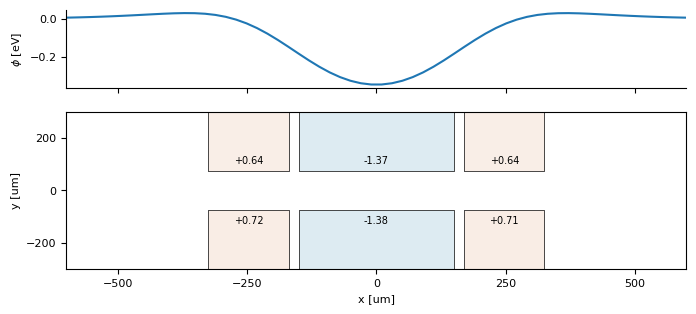

In [4]:
_ = plot_voltages_on_trap(trap, waveform[0])


## Mixed-species ion crystal

--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[-0.0021 -0.0011  0.0013]
Gradient [V/m]
[-0.034  -0.0979  0.1594]
Displacement at 1 MHz [um]
[-0.0021 -0.006   0.0097]
Hessian [V/m2]
[[ 1.6351e+07 -5.1332e+04  3.5093e+04]
 [-5.1332e+04  1.1695e+08  2.5000e+07]
 [ 3.5093e+04  2.5000e+07  1.4436e+08]]
Normal mode frequencies [MHz]
[1 2.49935 3.11992]
Eigenvectors
[[1 0.000608 -0.000393]
 [-0.000723 0.86 -0.51]
 [2.83e-05 0.51 0.86]]
Tilt angle of mode 2 (3.12): 59.37°
--------------
Mode solver analysis for ion crystal [Be9, Ca40, Ca40, Be9]: 
Equilibrium positions [um]
[[-6.3861 -0.0036 -0.0461]
 [-2.0258 -0.004   0.0087]
 [ 2.0097 -0.0005  0.0072]
 [ 6.3604 -0.0004 -0.0495]]
Normal modes
  Freq [MHz]                     Be9                                Ca40                               Ca40                                 Be9
------------  ----------  ----------  ----------  ----------  ----------  ---------  ----------  ----------  ----------  ------

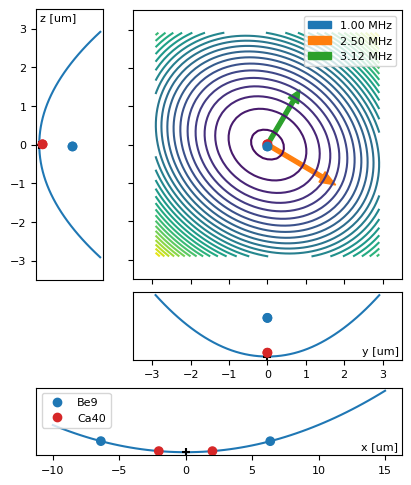

In [5]:
from pytrans.ions import Ca40, Be9
from pytrans.analysis import analyse_potential

r0 = (x0, 0, trap.z0)
# roi = (20e-6, 3.5e-6, 3.5e-6)
roi = ((x0 - 10e-6, x0 + 15e-6), 3.5e-6, 3.5e-6)

ions = [Be9, Ca40, Ca40, Be9]
res = analyse_potential(trap, voltages=waveform[0], ions=ions, ion1=Ca40, r0=r0, roi=roi, verbose=False)
res

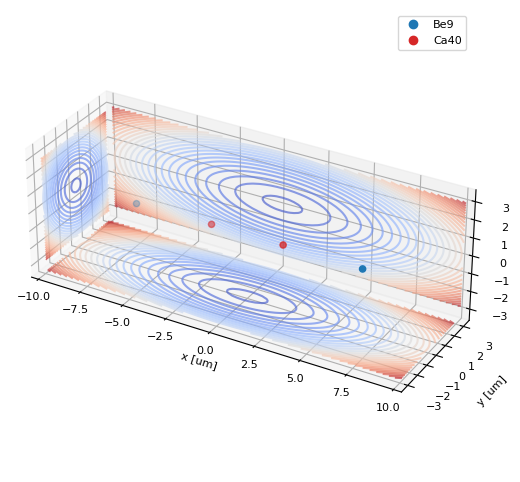

In [6]:
from pytrans.plotting import plot3d_potential

roi = (10e-6, 3.5e-6, 3.5e-6)
_ = plot3d_potential(trap, waveform[0], Ca40, r0, roi, analyse_results=res)